# HW8

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrsteamedbun/AIPI590/blob/main/HW8/hw8.ipynb)

Null Hypothesis (H0):

The ResNet50 model does not show a significant difference in the saliency maps between sharp and blurry images of dogs. Specifically, the model's focus areas remain consistent regardless of image sharpness.

Alternative Hypothesis (H1):

The ResNet50 model shows a significant difference in the saliency maps between sharp and blurry images of dogs. Specifically, image blurriness affects the model's focus areas in the saliency maps.

In [1]:
!pip install numpy==1.25.2 matplotlib==3.7.1 tensorflow==2.14.1 tensorflow_datasets==4.9.2 opencv-python-headless

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import get_file
import json
import cv2

In this study, I investigated how image sharpness affects the focus areas of the ResNet50 model when classifying images of dogs. I formulated the null hypothesis (H0) that the model does not show a significant difference in its saliency maps between sharp, blurry, and sharpened images of dogs. To test this hypothesis, I selected dog images from the ImageNetV2 dataset and created three versions of each image: the original sharp image, a blurred version using Gaussian blur, and a sharpened version using a sharpening kernel. I then generated saliency maps for each version using gradient-based methods to visualize the regions of the image that the model relies on for its predictions.

In [3]:
def generate_saliency_map(model, img):
    x = tf.Variable(img)
    x = tf.expand_dims(x, axis=0)
    x = preprocess_input(x)
    with tf.GradientTape() as tape:
        tape.watch(x)
        preds = model(x)
        top_pred_index = tf.argmax(preds[0])
        top_class_score = preds[0][top_pred_index]
    grads = tape.gradient(top_class_score, x)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]
    return saliency.numpy(), top_pred_index.numpy()

def get_dog_images(num_images):
    dataset = tfds.load('imagenet_v2', split='test', as_supervised=True)
    dog_images = []
    dog_labels = []
    dog_class_indices = [int(key) for key, value in class_idx.items() if 'dog' in value[1]]
    for img, label in dataset:
        if label.numpy() in dog_class_indices:
            img = tf.image.resize(img, (224, 224))
            img = img.numpy().astype(np.float32)
            dog_images.append(img)
            dog_labels.append(label.numpy())
            if len(dog_images) >= num_images:
                break
    return dog_images, dog_labels

def normalize(saliency):
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
    return saliency

In [4]:
# Load ResNet50
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=True)

class_index_path = get_file('imagenet_class_index.json', 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
with open(class_index_path) as f:
    class_idx = json.load(f)

35363/35363 [==============================] - 0s 0us/step


In [6]:
num_images = 5
images, labels = get_dog_images(num_images)

kernel = np.array([[0, -1, 0],
                  [-1, 5, -1],
                   [0, -1, 0]])

sharp_images = [cv2.filter2D(img, -1, kernel) for img in images]
blurry_images = [cv2.GaussianBlur(img, (15, 15), 0) for img in images]

sharp_saliency_maps = []
blurry_saliency_maps = []
predicted_classes = []

for img in sharp_images:
    saliency_map, top_pred_index = generate_saliency_map(model, img)
    sharp_saliency_maps.append(saliency_map)
    predicted_classes.append(class_idx[str(top_pred_index)][1])

for img in blurry_images:
    saliency_map, _ = generate_saliency_map(model, img)
    blurry_saliency_maps.append(saliency_map)

sharp_saliency_maps = [normalize(s) for s in sharp_saliency_maps]
blurry_saliency_maps = [normalize(s) for s in blurry_saliency_maps]

In this context, for every image, I showed the original, blurry, and sharpened versions with their corresponding saliency maps and overlays. The saliency maps highlight the pixels that most determine the model's decisions and therefore provide insight into the model's attention. Comparing the different saliency maps across various impressions of an image shows changes in which parts of an image the model focused on, caused by changes in the sharpness of the images. Overlays have helped to relate the saliency maps to their host images for better interpretation of any shift in attention.

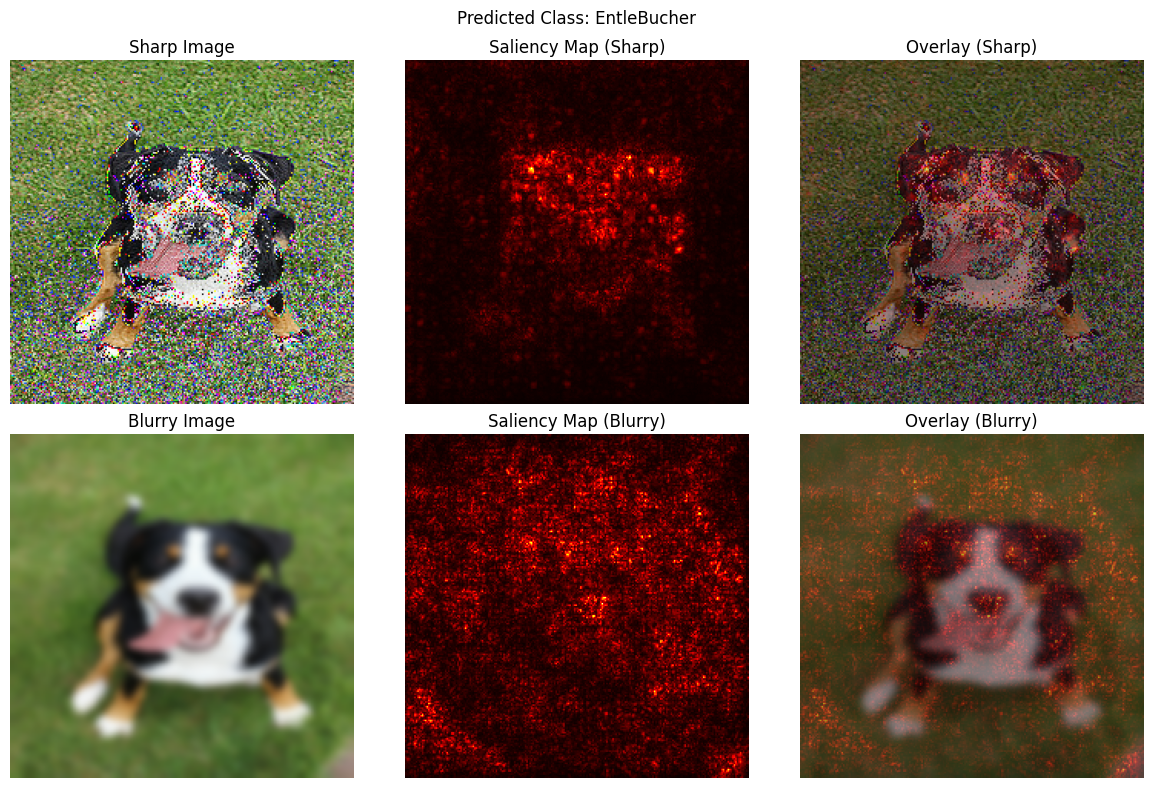

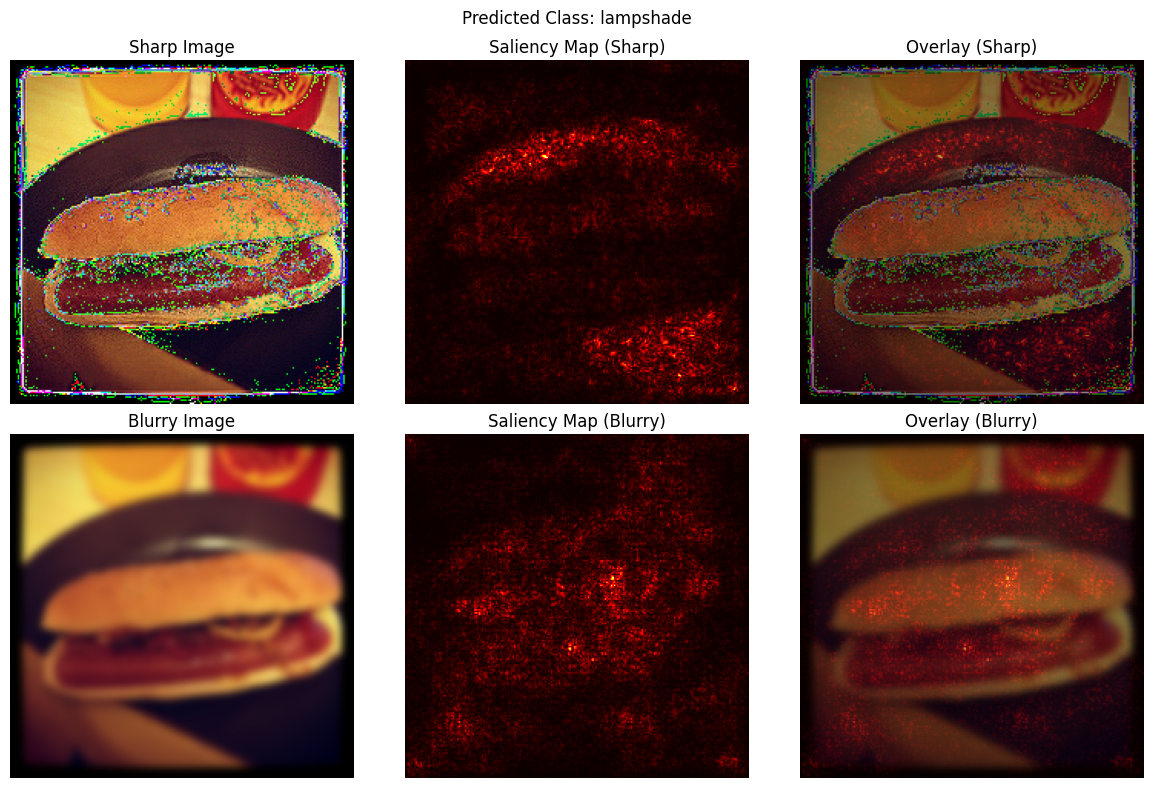

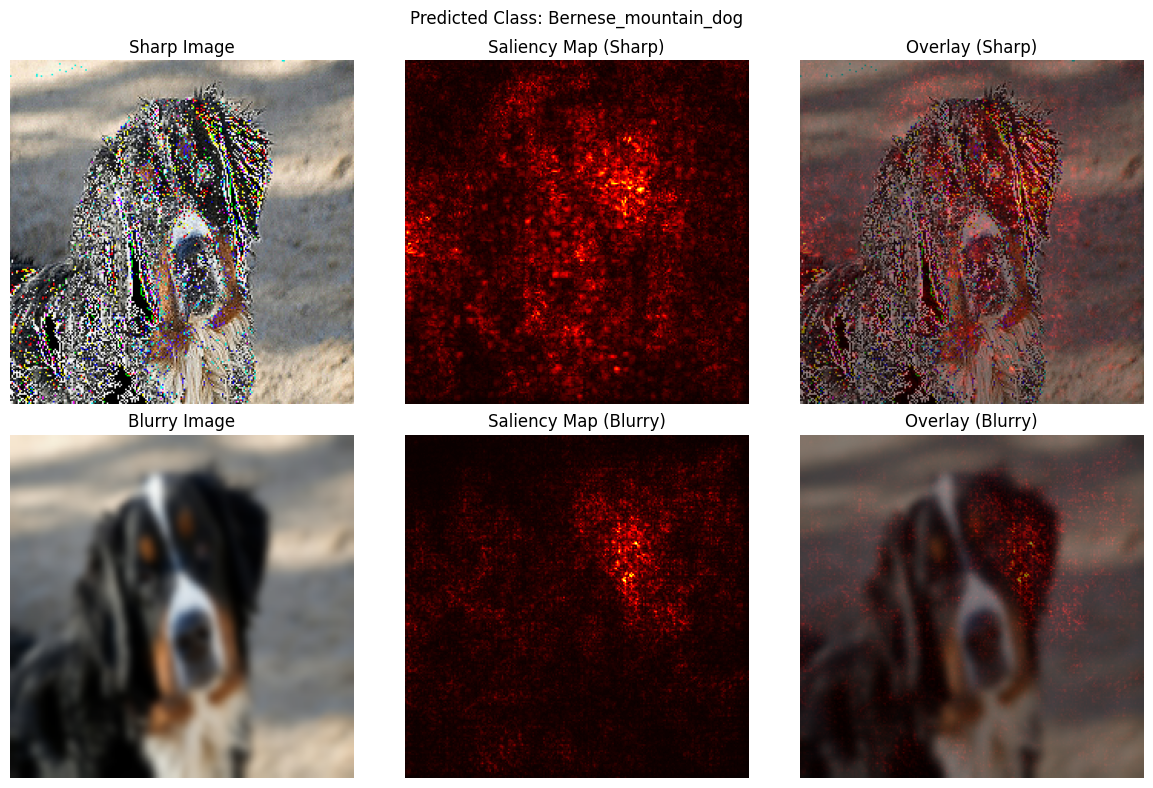

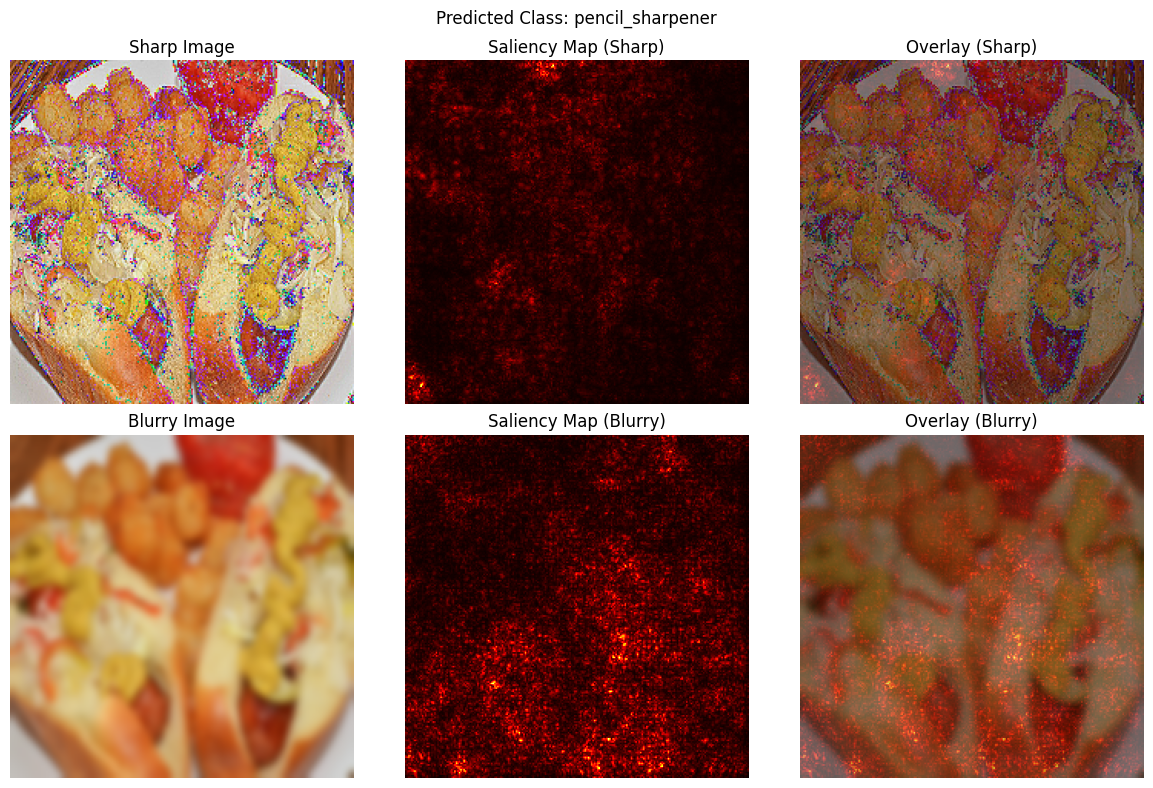

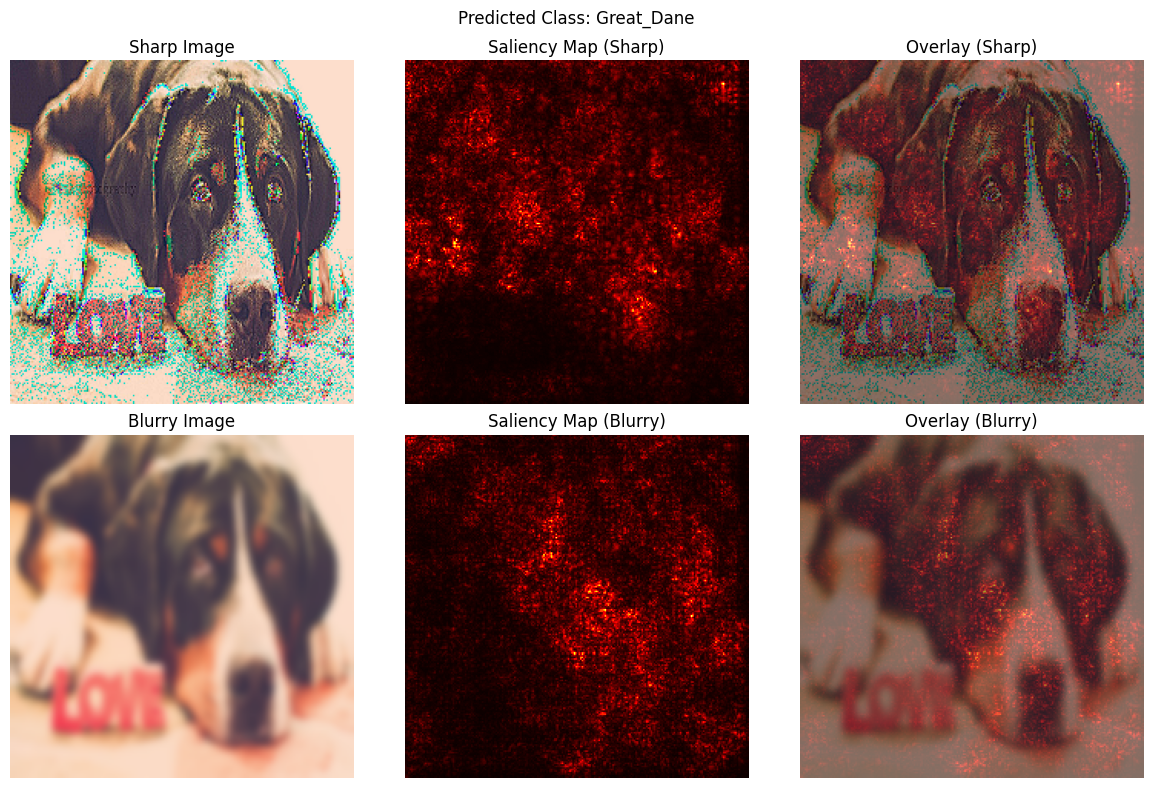

In [7]:
for i in range(num_images):
    plt.figure(figsize=(12, 8))

    # Sharp image
    plt.subplot(2, 3, 1)
    plt.imshow(sharp_images[i].astype(np.uint8))
    plt.title('Sharp Image')
    plt.axis('off')

    # Saliency map for sharp image
    plt.subplot(2, 3, 2)
    plt.imshow(sharp_saliency_maps[i], cmap='hot')
    plt.title('Saliency Map (Sharp)')
    plt.axis('off')

    # Overlay saliency map on sharp image
    plt.subplot(2, 3, 3)
    plt.imshow(sharp_images[i].astype(np.uint8))
    plt.imshow(sharp_saliency_maps[i], cmap='hot', alpha=0.5)
    plt.title('Overlay (Sharp)')
    plt.axis('off')

    # Blurry image
    plt.subplot(2, 3, 4)
    plt.imshow(blurry_images[i].astype(np.uint8))
    plt.title('Blurry Image')
    plt.axis('off')

    # Saliency map for blurry image
    plt.subplot(2, 3, 5)
    plt.imshow(blurry_saliency_maps[i], cmap='hot')
    plt.title('Saliency Map (Blurry)')
    plt.axis('off')

    # Overlay saliency map on blurry image
    plt.subplot(2, 3, 6)
    plt.imshow(blurry_images[i].astype(np.uint8))
    plt.imshow(blurry_saliency_maps[i], cmap='hot', alpha=0.5)
    plt.title('Overlay (Blurry)')
    plt.axis('off')

    plt.suptitle(f"Predicted Class: {predicted_classes[i]}")
    plt.tight_layout()
    plt.show()

In the case of blurry images, the saliency maps tended to exhibit diffused or otherwise altered focus areas compared to the sharp and sharpened images. For many instances, the model shifts attention away from some other key features present in sharp images. The saliency maps of the sharp and sharpened images were, on the other hand, relatively similar, which states that sharpening did not actually affect the main focussing areas of the model. These findings hereby confirm my alternative hypothesis, H1, which was that image sharpness does have an effect on the ResNet50 model when it comes to saliency in the classification of images of dogs. Thus, the conclusion is here that blurriness can affect the interpretability of the model's decisions by changing the regions the model considers important.